Attacks on ssh 

1) Convert the large pcap files into small files using tcpdump

In [2]:
#run the command 
#tcpdump -r input_file.pcap -w output_file -C <size>

#I have used size of 100mb for each pcap files

2) Convert the pcap files into csv files using tshark (command line wireshark tools) for each of the small files
    a filter of port==22 is made to isolate all the ssh packets.

In [3]:
import os

for file in os.listdir('./datasets_pcap/'):
    #print(file)
    os.system(f'echo Time,IPsrc,IPdst,srcPort,dstPort,length > ./datasets_csv/{file}.csv')
    os.system(f'tshark -r ./datasets_pcap/{file} -Y "tcp.srcport==22 || tcp.dstport==22" -T fields -e frame.time -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport -e ip.len >> ./datasets_csv/{file}.csv')
    print(f"converted {file}")

converted small_datasets
converted small_datasets1
converted small_datasets10
converted small_datasets100
converted small_datasets101
converted small_datasets102
converted small_datasets103
converted small_datasets104
converted small_datasets105
converted small_datasets106
converted small_datasets107
converted small_datasets108
converted small_datasets109
converted small_datasets11
converted small_datasets110
converted small_datasets111
converted small_datasets25
converted small_datasets26
converted small_datasets27
converted small_datasets28
converted small_datasets29
converted small_datasets3
converted small_datasets30
converted small_datasets31
converted small_datasets32
converted small_datasets33
converted small_datasets34
converted small_datasets35
converted small_datasets36
converted small_datasets37
converted small_datasets38
converted small_datasets39
converted small_datasets40
converted small_datasets41
converted small_datasets42
converted small_datasets43
converted small_data

In [4]:
#for checking and deleting all the files which are not related to ssh
import os
for file in os.listdir('./datasets_csv/'):
    f=open(f'./datasets_csv/{file}','r')
    count=0
    for line in f:
        count+=1
        if(count>1):
            break

    if(count==1):
        print(f'deleting the file {file}')
        os.system(f'rm ./datasets_csv/{file}')

deleting the file small_datasets1.csv
deleting the file small_datasets10.csv
deleting the file small_datasets100.csv
deleting the file small_datasets101.csv
deleting the file small_datasets102.csv
deleting the file small_datasets103.csv
deleting the file small_datasets104.csv
deleting the file small_datasets105.csv
deleting the file small_datasets106.csv
deleting the file small_datasets107.csv
deleting the file small_datasets108.csv
deleting the file small_datasets109.csv
deleting the file small_datasets11.csv
deleting the file small_datasets110.csv
deleting the file small_datasets111.csv
deleting the file small_datasets112.csv
deleting the file small_datasets113.csv
deleting the file small_datasets114.csv
deleting the file small_datasets115.csv
deleting the file small_datasets116.csv
deleting the file small_datasets117.csv
deleting the file small_datasets118.csv
deleting the file small_datasets119.csv
deleting the file small_datasets12.csv
deleting the file small_datasets120.csv
delet

In [15]:
import os

for file_name in os.listdir('./datasets_csv/'):
    if 'small' not in file_name:
        continue
    file=open(f'./datasets_csv/{file_name}')
    count=0;
    
    for line in file:
        
        if(count==0):
            os.system(f'echo Abstime,IPsrc,IPdst,srcPort,dstPort,size > ./cleaned_csvs/cleaned_{file_name}')
            count+=1
            continue
        line=line.strip()
        line=line.split("\t")
        #print(line)
        
        #getting the datetime
        datetime=line[0]
        datetime=datetime.split(" ")
        datetime=datetime[4]
        splitdatetime=datetime.split(":")
        hours=splitdatetime[0]
        mins=splitdatetime[1]
        secs=splitdatetime[2]
        abstime=float(hours)*3600.0+float(mins)*60+float(secs)
        os.system(f'echo {abstime},{line[1]},{line[2]},{line[3]},{line[4]},{line[5]} >> ./cleaned_csvs/cleaned_{file_name}')

        #print(abstime)

    file.close()
    


In [16]:
import os 

for file in os.listdir('./cleaned_csvs/'):
    if 'small' not in file:
        os.system(f'rm ./cleaned_csvs/{file}')

We are done with cleaning of data and have converted the pcap files into csv files with columns as
Absolute time (considering the data is single day's date)
#IPsrc
#IPdst
#srcPort
#dstPort
#size

In [58]:
import numpy as np
import pandas as pd

class connection:
    def __init__(self,host,server,hostport,serverport) -> None:
        self.host=host
        self.server=server
        self.hostport=hostport
        self.serverport=serverport
        self.size=list()
        self.starttime=float('inf')
        self.endtime=-float('inf')
        self.no_of_packets=0

    def add_to_aggregate(self,size,time):
        self.starttime=min(self.starttime,time)
        self.endtime=max(self.endtime,time)
        self.no_of_packets+=1
        self.size.append(size)

    def compare_connection(self,host,server,hostport,serverport):
        if self.host!=host:
            return False
        if self.server!=server:
            return False
        if self.hostport!=hostport:
            return False
        if self.serverport!=serverport:
            return False
        return True
    
    def print_connection(self):
        size_arr=np.array(self.size)
        #print(self.no_of_packets,np.average(size_arr),np.median(size_arr),np.std(size_arr),-self.starttime+self.endtime)
        os.system(f'echo {self.no_of_packets}, {np.average(size_arr)},{np.median(size_arr)},{np.std(size_arr)},{self.endtime-self.starttime} >> extracted_dataset.csv')

class connections:
    def __init__(self) -> None:
        self.connectionlist=list()

    def addconnection(self,connection):
        self.connectionlist.append(connection)
    
    def getconnection(self,host,server,hostport,serverport):
        for conn in self.connectionlist:
            if(conn.compare_connection(host,server,hostport,serverport)):
                return conn
        conn=connection(host,server,hostport,serverport)
        self.addconnection(connection=conn)
        return conn
    
    def print_connections(self):
        os.system('echo packets_count, average_size,median_size,std_size,duration > extracted_dataset.csv')
        for conn in self.connectionlist:
            conn.print_connection()



connections=connections()

In [59]:
import pandas as pd
import os

for file in os.listdir('./cleaned_csvs/'):

    df=pd.read_csv(f'./cleaned_csvs/{file}')

    #print(df.iloc[0],df.iloc[1])
    #al=df.iloc[0]
    rows=df[df.columns[0]].count()
    #rows

    for i in range(rows):
        rrow=df.iloc[i]
        if rrow['srcPort']==22:
            host=rrow['IPdst']
            server=rrow['IPsrc']
            hostport=rrow['dstPort']
            serverport=rrow['srcPort']
            size=rrow['size']
            time=rrow['Abstime']

            conn=connections.getconnection(host=host,server=server,hostport=hostport,serverport=serverport)
            conn.add_to_aggregate(size,time)
        
        elif rrow['dstPort']==22:
            host=rrow['IPsrc']
            server=rrow['IPdst']
            hostport=rrow['srcPort']
            serverport=rrow['dstPort']
            size=rrow['size']
            time=rrow['Abstime']

            conn=connections.getconnection(host=host,server=server,hostport=hostport,serverport=serverport)
            conn.add_to_aggregate(size,time)


connections.print_connections()

The extracted dataset which contains the no of packets, avg_size, median_size, std_size, duration

Total rows:  4023


/media/saikiran/Common disk/RnD1/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


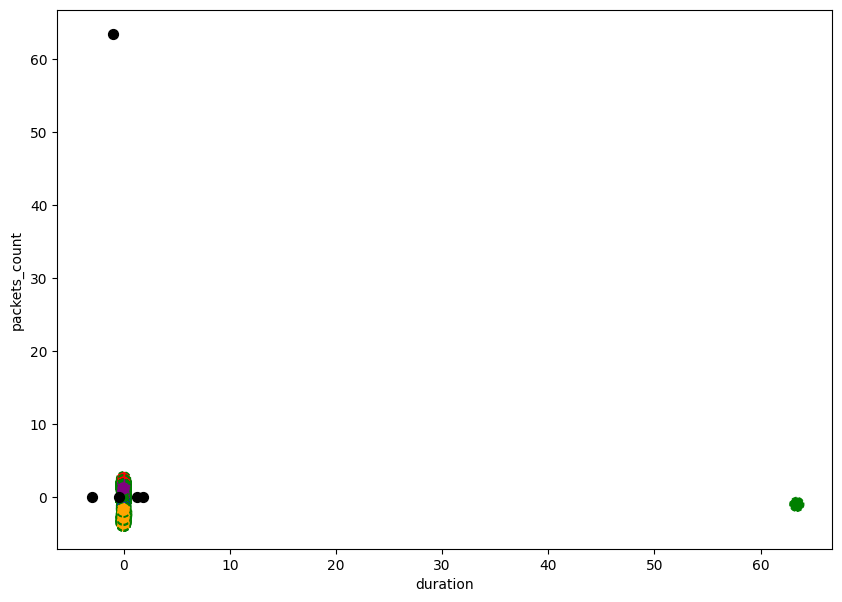

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

dfa=pd.read_csv("extracted_dataset.csv")
dfa=dfa[['packets_count','duration']]
print("Total rows: ",len(dfa))

sc_dfa=StandardScaler()
dfa_std=sc_dfa.fit_transform(dfa.astype(float))

kmeans=KMeans(n_clusters=5,random_state=42).fit(dfa_std)
labels=kmeans.labels_


new_dfa=pd.DataFrame(data=dfa_std,columns=['packets_count','duration'])
new_dfa['label_kmeans']=labels

fig,ax=plt.subplots(figsize=(10,7))
plt.scatter(new_dfa["duration"][new_dfa["label_kmeans"] == 0], new_dfa["packets_count"][new_dfa["label_kmeans"] == 0], 
            color = "blue", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["duration"][new_dfa["label_kmeans"] == 1], new_dfa["packets_count"][new_dfa["label_kmeans"] == 1], 
            color = "red", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["duration"][new_dfa["label_kmeans"] == 2], new_dfa["packets_count"][new_dfa["label_kmeans"] == 2], 
            color = "green", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["duration"][new_dfa["label_kmeans"] == 3], new_dfa["packets_count"][new_dfa["label_kmeans"] == 3], 
            color = "orange", s=100, edgecolor='green',linestyle='--')

plt.scatter(new_dfa["duration"][new_dfa["label_kmeans"] == 4], new_dfa["packets_count"][new_dfa["label_kmeans"] == 4], 
            color = "purple", s=100, edgecolor='green',linestyle='--')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50);
ax.set_xlabel('duration')
ax.set_ylabel('packets_count')
#plt.show()
plt.savefig('./2_features.png')

Total Row :  4023


/media/saikiran/Common disk/RnD1/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


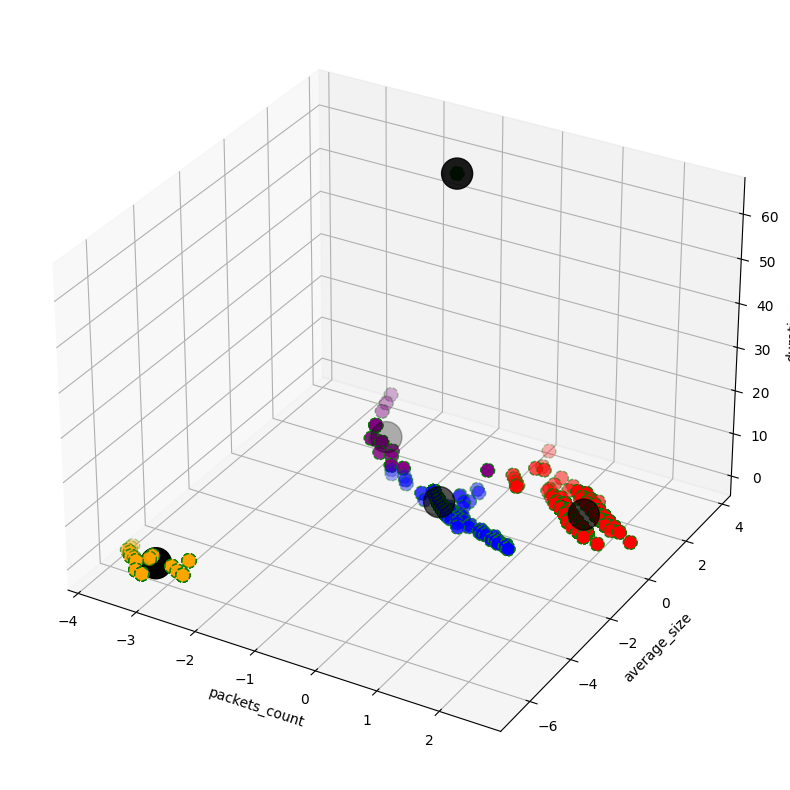

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

dfa = pd.read_csv('extracted_dataset.csv')
dfa = dfa[['packets_count',' average_size','duration']]
print('Total Row : ', len(dfa))
## Feature Scaling
sc_dfa = StandardScaler()
dfa_std = sc_dfa.fit_transform(dfa.astype(float))
## Clustering with KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(dfa_std)
labels = kmeans.labels_
new_dfa = pd.DataFrame(data = dfa_std, columns = ['packets_count','average_size','duration'])
new_dfa['label_kmeans'] = labels

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(new_dfa['packets_count'][new_dfa.label_kmeans == 0], new_dfa['average_size'][new_dfa.label_kmeans == 0], new_dfa['duration'][new_dfa.label_kmeans == 0], c='blue', s=100, edgecolor='green',linestyle="--")

ax.scatter(new_dfa['packets_count'][new_dfa.label_kmeans == 1], new_dfa['average_size'][new_dfa.label_kmeans == 1], new_dfa['duration'][new_dfa.label_kmeans == 1], c='red', s=100, edgecolor='green',linestyle="--")

ax.scatter(new_dfa['packets_count'][new_dfa.label_kmeans == 2], new_dfa['average_size'][new_dfa.label_kmeans == 2], new_dfa['duration'][new_dfa.label_kmeans == 2], c='green', s=100, edgecolor='green',linestyle="--")

ax.scatter(new_dfa['packets_count'][new_dfa.label_kmeans == 3], new_dfa['average_size'][new_dfa.label_kmeans == 3], new_dfa['duration'][new_dfa.label_kmeans == 3], c='orange', s=100, edgecolor='green',linestyle="--")

ax.scatter(new_dfa['packets_count'][new_dfa.label_kmeans == 4], new_dfa['average_size'][new_dfa.label_kmeans == 4], new_dfa['duration'][new_dfa.label_kmeans == 4], c='purple', s=100, edgecolor='green',linestyle="--")

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=500);
plt.xlabel('packets_count')
plt.ylabel('average_size')
ax.set_zlabel('duration')
#plt.show()
plt.savefig('./3_features.png')

In [50]:
import pandas as pd

df=pd.read_csv('./labels.csv')

rows=df[df.columns[0]].count()


class conn:
    def __init__(self,host,server,hostport,serverport) -> None:
        self.host=host
        self.server=server
        self.hostport=hostport
        self.serverport=serverport
        self.label=''
    
    def compare_conn(self,host,server,hostport,serverport):
        if self.host!=host:
            return False
        if self.server!=server:
            return False
        if self.hostport!=hostport:
            return False
        if self.serverport!=serverport:
            return False
        return True
    
    def get_label(self):
        return self.label
    
    def set_label(self,label):
        if self.label != 'SSH-Patator':
            self.label=label


class conns:
    def __init__(self) -> None:
        self.connlist=list()
    
    def addconn(self,conn):
        self.connlist.append(conn)
    
    def getconn(self,host,server,hostport,serverport):
        for f in self.connlist:
            if(f.compare_conn(host=host,server=server,hostport=hostport,serverport=serverport)):
                return f
        con=conn(host=host,server=server,hostport=hostport,serverport=serverport)
        self.addconn(con)
        return con
    
    def get_ssh_count(self):
        count=0
        ssh_count=0

        for e in self.connlist:
            if (e.get_label()=='SSH-Patator'):
                ssh_count+=1
            count+=1

        return ssh_count,count

conns=conns()


In [51]:

for i in range(rows):
    rrow=df.iloc[i]

    if(rrow[' Source Port']==22):
        host=rrow[' Destination IP']
        server=rrow[' Source IP']
        hostport=rrow[' Destination Port']
        serverport=rrow[' Source Port']
        
        label=rrow[' Label']

        con=conns.getconn(host=host,server=server,hostport=hostport,serverport=serverport)

        con.set_label(label)

    if(rrow[' Destination IP']==22):
        server=rrow[' Destination IP']
        host=rrow[' Source IP']
        serverport=rrow[' Destination Port']
        hostport=rrow[' Source Port']
        
        label=rrow[' Label']

        con=conns.getconn(host=host,server=server,hostport=hostport,serverport=serverport)

        con.set_label(label)


conns.get_ssh_count()


(0, 1035)

We had around 4024 connections out of which we had 46 around as actual ssh attacks, our model detected with 84 connections as possible attacks, with a true positive rate of 43/46 and flase positive rate of 41 which is around 50% in detecting the a benign user who mis typed password roughly 3.2 times to classify as non benign user, as a next phase I will address the issue of detecting from the regular users from the references.

In [49]:
import pandas as pd
df=pd.read_csv('./labels.csv')

df=df[' Label']

for f in df:
    if f=='SSH-Patator':
        print(f)

SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-Patator
SSH-